<a href="https://colab.research.google.com/github/martinpius/Applied-Predictive-Modeling2/blob/master/Classification_Model_Training_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are on colab with tensorflow version: {tf.__version__}")
except Exception as e:
  COLAB = False
  print(f"{type(e)}: {e}\n...Please Load Your Drive...")

def time_fmt(x):
  h = int(x / (60 * 60))
  m = int(x % (60 * 60)/60)
  s = int(x % 60)
  return f"{h}: {m:>03}: {s:>05.2f}"

print(f"testing time: {time_fmt(123.8464)}")

Mounted at /content/drive
You are on colab with tensorflow version: 2.4.1
testing time: 0: 002: 03.00


In [ ]:
#We are going to train a classification model on mnist dataset from scratch:
import tensorflow as tf
import time
import numpy as np

In [ ]:
#Get and prepare the data from keras:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
print(f"x_train_shape: {x_train.shape}, y_train_shape: {y_train.shape}\nx_test_shape: {x_test.shape}, y_test_shape: {y_test.shape}")

x_train_shape: (60000, 28, 28), y_train_shape: (60000,)
x_test_shape: (10000, 28, 28), y_test_shape: (10000,)


In [ ]:
x_train, x_test = x_train.astype(np.float32)/255.0, x_test.astype(np.float32)/255.0
x_train, x_test = x_train.reshape((60000, 784)), x_test.reshape((10000, 784))

In [ ]:
y_train, y_test = tf.keras.utils.to_categorical(y_train, num_classes = 10), tf.keras.utils.to_categorical(y_test, num_classes = 10)

In [ ]:
#We first build and train the simple mlp on the mnist dataset from the scratch:
BATCH_SIZE = 64
BUFFER = 1024
EPOCHS = 10


In [ ]:
train_dfm = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dfm = train_dfm.shuffle(BUFFER).batch(BATCH_SIZE, drop_remainder = True)
validation_dfm = tf.data.Dataset.from_tensor_slices((x_test, y_test))
validation_dfm = validation_dfm.shuffle(BUFFER).batch(BATCH_SIZE, drop_remainder = True)

In [ ]:
sample_train_batch_x, sample_train_batch_y = next(iter(train_dfm))

In [ ]:
print(f"sample_train_batch_shape: {sample_train_batch_x.shape}\nsample_train_batch_y: {sample_train_batch_y.shape}")

sample_train_batch_shape: (64, 784)
sample_train_batch_y: (64, 10)


In [ ]:
#Build the mlp for classification:


Model: "mlp_mnist"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_shape (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               100480    
_________________________________________________________________
dense2 (Dense)               (None, 128)               16512     
_________________________________________________________________
dense3 (Dense)               (None, 64)                8256      
_________________________________________________________________
outputs (Dense)              (None, 10)                650       
Total params: 125,898
Trainable params: 125,898
Non-trainable params: 0
_________________________________________________________________


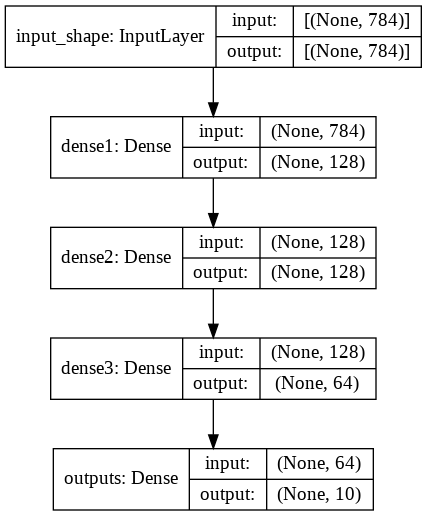

In [ ]:
inputs = tf.keras.Input(shape = (784,), name = 'input_shape')
x = tf.keras.layers.Dense(units = 128, kernel_initializer = 'random_normal', activation = 'relu', name = 'dense1')(inputs)
x = tf.keras.layers.Dense(units = 128, kernel_initializer = 'random_normal', activation = 'relu', name = 'dense2')(x)
x = tf.keras.layers.Dense(units = 64, kernel_initializer = 'random_normal', activation = 'relu', name = 'dense3')(x)
outputs = tf.keras.layers.Dense(units = 10, activation = 'softmax', name = 'outputs')(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs,name = 'mlp_mnist')
model.summary()
tf.keras.utils.plot_model(model = model, to_file = "mlp_mnist.png", show_shapes = True)

In [ ]:
#Get the loss function, metrics and the optimizer:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
metric_train = tf.keras.metrics.CategoricalAccuracy()
metric_eval = tf.keras.metrics.CategoricalAccuracy()

In [ ]:
#Training loop from the scratch:
tic = time.time()
for epoch in range(EPOCHS):
  print(f"The start of epoch: {epoch}")
  for (step, (x_train_batch, y_train_batch)) in enumerate(train_dfm):
    with tf.GradientTape() as tape:
      y_preds = model(x_train_batch, training = True)
      loss = loss_fn(y_train_batch, y_preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    metric_train.update_state(y_train_batch, y_preds)
    train_acc = metric_train.result()
    metric_train.reset_states()
    if step % 200 == 0:
      print(f"epoch: {epoch}, training accuracy: {float(train_acc):.4f}")
      print(f"batch {step + 1} train loss: {float(loss): .4f}")
    
  for (step, (x_val_batch, y_val_batch)) in enumerate(validation_dfm):
    y_preds = model(x_val_batch, training = False)
    loss = loss_fn(y_val_batch, y_preds)
    metric_eval.update_state(y_val_batch, y_preds)
    val_acc = metric_eval.result()
    metric_eval.reset_states()

    if step % 200 == 0:
      print(f"epoch: {epoch}, validation accuracy: {float(val_acc):.4f}")
      print(f"batch: {step + 1}: validation loss: {float(loss):.4f}")

toc = time.time()
print(f"time elapse is : {time_fmt(toc - tic)}")


The start of epoch: 0
epoch: 0, training accuracy: 0.0625
batch 1 train loss:  2.3086
epoch: 0, training accuracy: 0.9531
batch 201 train loss:  0.3478
epoch: 0, training accuracy: 0.9375
batch 401 train loss:  0.2536
epoch: 0, training accuracy: 0.9688
batch 601 train loss:  0.1454
epoch: 0, training accuracy: 0.9531
batch 801 train loss:  0.1437
epoch: 0, validation accuracy: 0.9844
batch: 1: validation loss: 0.0549
The start of epoch: 1
epoch: 1, training accuracy: 0.9531
batch 1 train loss:  0.1359
epoch: 1, training accuracy: 0.9531
batch 201 train loss:  0.1681
epoch: 1, training accuracy: 0.9688
batch 401 train loss:  0.1244
epoch: 1, training accuracy: 0.9531
batch 601 train loss:  0.1178
epoch: 1, training accuracy: 0.9688
batch 801 train loss:  0.0950
epoch: 1, validation accuracy: 0.9844
batch: 1: validation loss: 0.0730
The start of epoch: 2
epoch: 2, training accuracy: 0.9375
batch 1 train loss:  0.2125
epoch: 2, training accuracy: 0.9688
batch 201 train loss:  0.0680
epoc

In [ ]:
#We can fit the cnn to the same data to classify the mnist images:

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
x_train, x_test = x_train.astype(np.float32)/255.0, x_test.astype(np.float32)/255.0

In [ ]:
y_train, y_test = tf.keras.utils.to_categorical(y_train, num_classes = 10), tf.keras.utils.to_categorical(y_test, num_classes = 10)

In [ ]:
x_train, x_test = x_train.reshape((60000, 28,28,1)), x_test.reshape((10000, 28,28,1))
print(f"x_train_shape: {x_train.shape}, y_train_shape: {y_train.shape}\nx_test_shape: {x_test.shape}, y_test_shape: {y_test.shape}")

x_train_shape: (60000, 28, 28, 1), y_train_shape: (60000, 10)
x_test_shape: (10000, 28, 28, 1), y_test_shape: (10000, 10)


In [ ]:
#Convert to tensorflow datatype:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_data = train_data.shuffle(BUFFER).batch(BATCH_SIZE, drop_remainder = True)
validation_data = validation_data.shuffle(BUFFER).batch(BATCH_SIZE, drop_remainder = True)
x_sample_train_batch, y_sample_train_batch = next(iter(train_data))
print(f"x_sample_train_batch_shape: {x_sample_train_batch.shape}\ny_train_batch_shape: {y_sample_train_batch.shape}")


x_sample_train_batch_shape: (64, 28, 28, 1)
y_train_batch_shape: (64, 10)


Model: "cnn_mnist"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_dim (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_norm (BatchNormalizati (None, 28, 28, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18

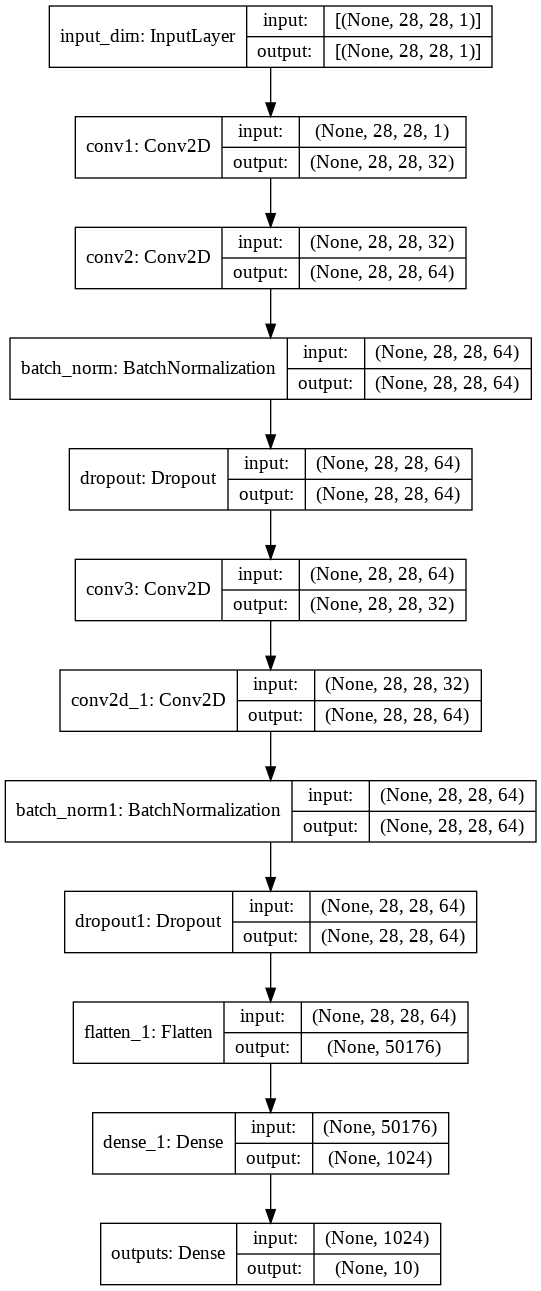

In [ ]:
#Building the cnn (simple cnn to train mnist data)
inputs = tf.keras.Input(shape = (28,28,1), name = 'input_dim')
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), kernel_initializer = 'random_normal', 
                           padding = 'same', strides = (1,1), activation = 'relu', name = 'conv1')(inputs)
x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',
                           strides = (1,1), activation = 'relu', kernel_initializer = 'random_normal', name = 'conv2')(x)
x = tf.keras.layers.BatchNormalization(name = 'batch_norm')(x)
x = tf.keras.layers.Dropout(rate = 0.5, name = 'dropout')(x)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3),
                           padding = 'same', activation = 'relu',
                           kernel_initializer = 'random_normal',strides = (1,1),
                           name = 'conv3')(x)
x = tf.keras.layers.Conv2D(filters = 64, 
                           kernel_size = (3,3),
                           activation = 'relu', padding = 'same',
                           strides = (1,1),kernel_initializer = 'random_normal')(x)
x = tf.keras.layers.BatchNormalization(name = 'batch_norm1')(x)
x = tf.keras.layers.Dropout(rate = 0.5, name = 'dropout1')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units = 1024, kernel_initializer = 'random_normal', activation = 'relu')(x)
outputs = tf.keras.layers.Dense(units = 10, activation = 'softmax', name = 'outputs')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'cnn_mnist')
model.summary()
tf.keras.utils.plot_model(model = model, to_file = 'cnn_mnist.png', show_shapes = True)

In [ ]:
#Get the loss object, optimizers and metrics

In [ ]:
loss_obj = tf.keras.losses.CategoricalCrossentropy()
train_metric = tf.keras.metrics.CategoricalAccuracy()
eval_metric = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.RMSprop()

In [ ]:
#Training the cnn with training loop from the scratch:

In [ ]:
tic = time.time()
for epoch in range(EPOCHS):
  print(f"The begining of epoch: {epoch}")
  for (step, (x_train_batch, y_train_batch)) in enumerate(train_data):
    with tf.GradientTape() as tape:
      y_preds = model(x_train_batch, training = True)
      train_loss = loss_obj(y_train_batch, y_preds)
    grads = tape.gradient(train_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_metric.update_state(y_train_batch, y_preds)
    train_acc = train_metric.result()
    train_metric.reset_states()
    if step % 200 == 0:
      print(f"epoch: {epoch}: train_accuracy is: {float(train_acc):.4f}")
      print(f"batch: {step + 1}: train loss is: {float(train_loss):.4f}")
  
  for (step, (x_val_batch, y_val_batch)) in enumerate(validation_data):
    y_preds = model(x_val_batch, training = False)
    val_loss = loss_obj(y_val_batch, y_preds)
    eval_metric.update_state(y_val_batch, y_preds)
    val_acc = eval_metric.result()
    eval_metric.reset_states()
    if step % 200 == 0:
      print(f"epoch: {epoch}: validation accuracy: {float(val_acc):.4f}")
      print(f"batch: {step + 1}: validation loss: {float(val_loss):.4f}")

toc = time.time()
print(f"time elapse is : {time_fmt(toc - tic)}")


The begining of epoch: 0
epoch: 0: train_accuracy is: 0.0156
batch: 1: train loss is: 26.5318
epoch: 0: train_accuracy is: 0.8906
batch: 201: train loss is: 0.7525
epoch: 0: train_accuracy is: 0.9219
batch: 401: train loss is: 0.4345
epoch: 0: train_accuracy is: 0.9062
batch: 601: train loss is: 0.4793
epoch: 0: train_accuracy is: 0.9844
batch: 801: train loss is: 0.0306
epoch: 0: validation accuracy: 0.9844
batch: 1: validation loss: 0.0916
The begining of epoch: 1
epoch: 1: train_accuracy is: 0.9375
batch: 1: train loss is: 0.1468
epoch: 1: train_accuracy is: 0.9844
batch: 201: train loss is: 0.1257
epoch: 1: train_accuracy is: 0.9688
batch: 401: train loss is: 0.1656
epoch: 1: train_accuracy is: 0.9531
batch: 601: train loss is: 0.1448
epoch: 1: train_accuracy is: 0.9688
batch: 801: train loss is: 0.1759
epoch: 1: validation accuracy: 0.9688
batch: 1: validation loss: 0.1158
The begining of epoch: 2
epoch: 2: train_accuracy is: 0.9688
batch: 1: train loss is: 0.4296
epoch: 2: train_